# Installation

In [ ]:
!pip install transformers==4.30.2
!pip install sentencepiece
!pip install accelerate
!pip install datasets
!pip install einops

In [ ]:
!python --version # 3.10.12

# Google Drive Preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import

In [ ]:
import random
import argparse
import numpy as np
import pandas as pd
import math
import pickle
import json
from scipy import stats
import torch
import tqdm.notebook
from transformers import AutoTokenizer, AutoModelForCausalLM, logging, LlamaTokenizer, LlamaForCausalLM
from transformers.models.cvt.modeling_cvt import CrossEntropyLoss
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.ticker as ptick

torch.set_default_tensor_type('torch.cuda.FloatTensor')

In [ ]:
torch.__version__ # 2.1.0+cu121

# Huggingface Login

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

# Load Model

In [ ]:
model_name = "meta-llama/Llama-2-7b-hf"
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_name)
model.eval()

# Load Raw Preambles

In [7]:
# pooled preamble subsets (unsorted)
BASE_CC_PATH = '' # raw_preamble_randomly_generated.pkl
with open (BASE_CC_PATH, 'rb') as f:
    base_cc = pickle.load(f)

# N- preambles for each type (rondmuly selected and orderted 10 preambles per type)
RAND_CC_PATH = '' # raw_preamble_random_ordered.pkl
with open (RAND_CC_PATH, 'rb') as f:
    rand_cc = pickle.load(f)

# Build Evalation Data

In [ ]:
from datasets import load_dataset
data_cp = load_dataset("crows_pairs")
records = []
num_example = 0

for example in data_cp['test']:
    if example['bias_type'] == 2:
        record = {}
        record['stereotype'] = example['sent_more']
        record['anti-stereotype'] = example['sent_less']
        record['stereo_antistereo'] = example['stereo_antistereo']
        records.append(record)

# Sort and Select N-Preambles based on Pre-computed Perplexity

In [8]:
# computing perplexity for a given input text
def calc_perplexity(model, tokenizer, input_text):
    input_ids = tokenizer.encode(input_text, return_tensors='pt')
    label_ids = input_ids.clone()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, labels=label_ids)
        shift_logits = outputs.logits[:,:-1,:].contiguous()
        shift_labels = label_ids[:,1:].contiguous()
        loss_fct = CrossEntropyLoss()
        if shift_logits.dtype != torch.float32:
            shift_logits = shift_logits.to(torch.float32)
            assert shift_logits.dtype == torch.float32
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
        perplexity = torch.exp(loss)
        return perplexity.item()

# for sorting preambles based of perplexity
def sort_select_preambles(model, tokenizer, save_name, base_cc):
    seed = 0
    torch.cuda.empty_cache()
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    perp_DB = {} # for storing perplexity values of preambles
    model.to('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

    for key in base_cc.keys(): # NOTE: key represents preamble type (e.g., CF-simple)
        print('------  preamble type  ------- : ', key)
        perp_DB[key] = {}
        for input_sentence in tqdm.notebook.tqdm(base_cc[key]):
            with torch.no_grad():
                input_perplexity  = calc_perplexity(model, tokenizer, input_sentence)
                perp_DB[key][input_sentence] = input_perplexity

    SAVE_PATH = save_name + '_perp_DB.pkl'
    print('saving perplexity values of preambles into ... ', SAVE_PATH)
    with open (SAVE_PATH, 'wb') as f:
        pickle.dump(perp_DB, f)

    sorted_cc = {} # for storing sorted preambles based on the computed perplexity values
    for k in perp_DB.keys():
        tmp = sorted(perp_DB[k].items(), key=lambda x:x[1])[:15] # 15 preambles per type at maximum
        sorted_cc[k] = [x for x, y in tmp]

    SAVE_PATH = save_name + '_sorted_cc.pkl'
    print('saving low-perplexity premables into ... ', SAVE_PATH)
    with open (SAVE_PATH, 'wb') as f:
        pickle.dump(sorted_cc, f)

    return perp_DB, sorted_cc



In [ ]:
# Run
SAVE_PATH_PREFIX = ''
_, _ = sort_select_preambles(model, tokenizer, SAVE_PATH_PREFIX, base_cc)

# Downstream Evaluation

In [13]:
#### You need to download them preliminary ####
# https://github.com/mosaicml/llm-foundry/blob/main/scripts/eval/local_data/language_understanding/hellaswag.jsonl
# https://github.com/mosaicml/llm-foundry/blob/main/scripts/eval/local_data/commonsense_reasoning/copa.jsonl
COPA_PATH = ''
HS_PATH = ''
########################################

res_copa = []
decoder = json.JSONDecoder()
with open (COPA_PATH, 'r') as f:
    for line in f:
        data = json.loads(line)
        res_copa.append(data)

res_hella = []
decoder = json.JSONDecoder()
with open (HS_PATH, 'r') as f:
    for line in f:
        data = json.loads(line)
        res_hella.append(data)

def _tokenizer_needs_prefix_space(tokenizer) -> bool:
    return len(tokenizer(' a', add_special_tokens=False)['input_ids']) == 1

def _make_padded_input(context_enc, continuation_enc, max_seq_len, pad_tok_id):
    if len(continuation_enc) + len(context_enc) > max_seq_len:
        context_max_subseq_len = max_seq_len - len(continuation_enc)
        if context_max_subseq_len < 0:
            raise Exception(f'Dataset included continuation longer than the max seq len')
        context_enc = context_enc[-(context_max_subseq_len):]
    continuation_span = torch.tensor(range(len(context_enc), len(context_enc) + len(continuation_enc)))
    inp = torch.tensor((context_enc + continuation_enc), dtype=torch.long,)
    return inp, continuation_span

def run_glue(db_key, task='copa'):
    all_res_sum = []
    for num_index in tqdm.notebook.tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]):

        if db_key == "NONE":
            cf_context = None
        else: # db_key in ['t1', 't2', 't1_rand', 't2_rand']:
            LOAD_PATH = SAVE_PATH_PREFIX + '_sorted_cc.pkl'
            with open (LOAD_PATH, 'rb') as f:
                cc_sort_DB = pickle.load(f)
            cf_context = cc_sort_DB[db_key][:num_index]

        if task == 'hella':
            examples = []
            for sample in res_hella:
                choices = [(f'{choice}' if not choice.startswith(' ') else choice) for choice in sample['choices']]
                encoded_example = {}
                preamble = ' '
                encoded_example['preamble'] = tokenizer(preamble, add_special_tokens=False)
                encoded_example['gold_idx'] = sample['gold']
                encoded_example['query'] = tokenizer(sample['query'], add_special_tokens=False)
                encoded_example['choices'] = [tokenizer(choice, add_special_tokens=False) for choice in choices]
                examples.append(encoded_example)
        else:
            examples = []
            for sample in res_copa:
                choices = [(f'{choice}' if not choice.startswith(' ') else choice) for choice in sample['choices']]
                encoded_example = {}
                preamble = ' '
                encoded_example['preamble'] = tokenizer(preamble, add_special_tokens=False)
                encoded_example['gold_idx'] = sample['gold']
                encoded_example['query'] = tokenizer(sample['query'], add_special_tokens=False)
                encoded_example['choices'] = [tokenizer(choice, add_special_tokens=False) for choice in choices]
                examples.append(encoded_example)

        num_correct = 0
        num_total = 0
        seq_rec = []

        for example in examples[:100]:
            preamble, context, choices, gold_idx = (example['preamble'], example['query'], example['choices'], example['gold_idx'])
            inputs = []
            choice_spans = []
            res_perplexity = []
            for choice in choices:
                if cf_context:
                    cf_comb = ' '.join(cf_context)
                    cf_ids = tokenizer(cf_comb, add_special_tokens=False)
                    if len(preamble['input_ids']) == 0:
                        context_enc = cf_ids['input_ids'] + context['input_ids']
                    else:
                        context_enc = cf_ids['input_ids'] + preamble['input_ids'] + context['input_ids']
                else:
                    context_enc = context['input_ids']

                continuation_enc = choice['input_ids']

                input_ids, choice_span = _make_padded_input(context_enc, continuation_enc, tokenizer.model_max_length, tokenizer.pad_token_id)
                input_ids.unsqueeze_(0)
                label_ids = input_ids.clone()

                with torch.no_grad():
                    outputs = model(input_ids=input_ids, labels=label_ids)
                    shift_logits = outputs.logits[:,-1*len(choice_span):-1,:].contiguous()
                    shift_labels = label_ids[:,-1*len(choice_span)+1:].contiguous()

                    loss_fct = CrossEntropyLoss()

                    if shift_logits.dtype != torch.float32:
                        shift_logits = shift_logits.to(torch.float32)
                        assert shift_logits.dtype == torch.float32

                    loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
                    perplexity = torch.exp(loss)
                    perplexity = perplexity.item()
                    res_perplexity.append(perplexity)

            idx_min = res_perplexity.index(min(res_perplexity))
            if idx_min == gold_idx:
                num_correct += 1
            num_total += 1
        all_res_sum.append(num_correct)
        if db_key == "NONE":
            break
    return all_res_sum

In [ ]:
copa_srt_res = {}
hella_srt_res = {}

result_hella = run_glue('NONE', 'hella')[0]
result_copa = run_glue('NONE', 'copa')[0]
hella_srt_res['NONE'] = [result_hella for _ in range(10)]
copa_srt_res['NONE'] = [result_copa for _ in range(10)]
for k in ['t1', 't2', 't1_rand', 't2_rand']:
    copa_srt_res[k] = run_glue(k, 'copa')
for k in ['t1', 't2', 't1_rand', 't2_rand']:
    hella_srt_res[k] = run_glue(k, 'hella')

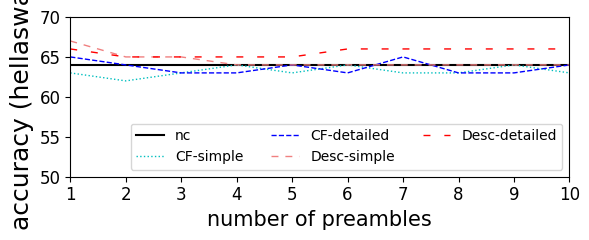

In [15]:
num_index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
fig = plt.figure(figsize=(6,2.5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("number of preambles", fontsize=15)
ax.set_ylabel("accuracy (hellaswag)", fontsize=18)

ax.set_xticks(num_index)
ax.set_yticks([50, 55, 60, 65, 70])
ax.tick_params(labelsize=12)

ax.plot(num_index, hella_srt_res['NONE'], label='nc', color='black')
ax.plot(num_index, hella_srt_res['t1'], label='CF-simple', linestyle = "dotted", linewidth = 1, color='c')
ax.plot(num_index, hella_srt_res['t2'], label='CF-detailed', linestyle = "dashed", linewidth = 1, color = 'b')
ax.plot(num_index, hella_srt_res['t1_rand'], label='Desc-simple', linestyle =  (0, (5, 5)), linewidth = 1, color = 'lightcoral')
ax.plot(num_index, hella_srt_res['t2_rand'], label='Desc-detailed', linestyle = (0, (5, 10)), linewidth =1, color='red')

ax.legend(fontsize=10, loc='lower right', ncol=3)
ax.set_xlim(1, 10)
ax.set_ylim(50, 70)

plt.tight_layout()
plt.show()

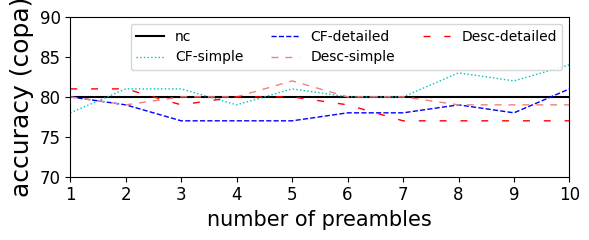

In [16]:
num_index = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
fig = plt.figure(figsize=(6,2.5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("number of preambles", fontsize=15)
ax.set_ylabel("accuracy (copa)", fontsize=18)

ax.set_xticks(num_index)
ax.set_yticks([70, 75, 80, 85, 90])
ax.tick_params(labelsize=12)

ax.plot(num_index, copa_srt_res['NONE'], label='nc', color='black')
ax.plot(num_index, copa_srt_res['t1'], label='CF-simple', linestyle = "dotted", linewidth = 1, color='c')
ax.plot(num_index, copa_srt_res['t2'], label='CF-detailed', linestyle = "dashed", linewidth = 1, color = 'b')
ax.plot(num_index, copa_srt_res['t1_rand'], label='Desc-simple', linestyle =  (0, (5, 5)), linewidth = 1, color = 'lightcoral')
ax.plot(num_index, copa_srt_res['t2_rand'], label='Desc-detailed', linestyle = (0, (5, 10)), linewidth =1, color='red')

ax.legend(fontsize=10, loc='upper right', ncol=3)
ax.set_xlim(1, 10)
ax.set_ylim(70, 90)

plt.tight_layout()
plt.show()